In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, LaplaceNoise, SmoothSecondDifference, \
    SmoothFirstDifference, SparseFirstDiffConvex, SparseSecondDiffConvex
from osd.utilities import progress

ImportError: cannot import name 'GaussNoise' from 'osd.components' (../osd/components/__init__.py)

In [22]:
def proj_l2_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(y) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(y)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d1(data, theta=1, c=1):
    """Sum of absolute value of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=1))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d2(data, theta=1, c=1):
    """Sum of absolute value of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=2))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d2(data, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=2)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d1(data, theta=1, c=1):
    """Sum of squares of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=1)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d3(data, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=3)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_dk(data, k, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=k)) / (len(x) - k) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

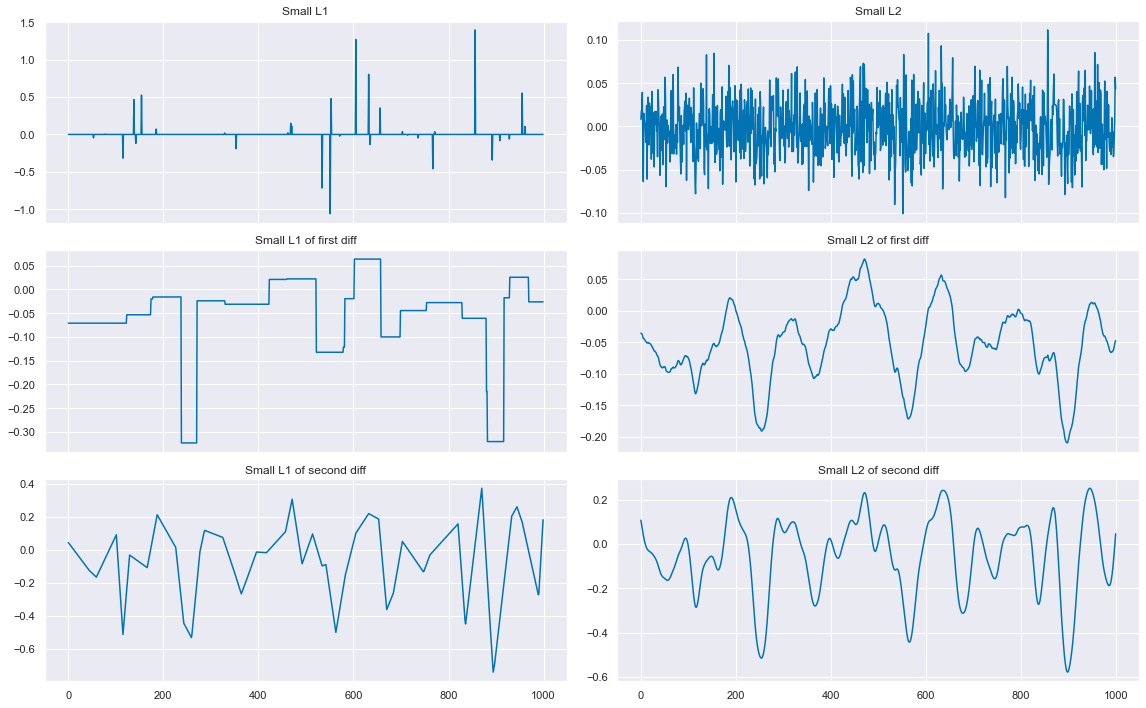

In [6]:

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 10), sharex=True)
ax[0, 0].plot(proj_l1_d0(x, theta=1e-1))
ax[0, 1].plot(proj_l2_d0(x))
ax[1, 0].plot(proj_l1_d1(x, theta=5e-1))
ax[1, 1].plot(proj_l2_d1(x, theta=1e2))
ax[2, 0].plot(proj_l1_d2(x))
ax[2, 1].plot(proj_l2_d2(x, theta=5e2))
ax[0, 0].set_title('Small L1')
ax[0, 1].set_title('Small L2')
ax[1, 0].set_title('Small L1 of first diff')
ax[1, 1].set_title('Small L2 of first diff')
ax[2, 0].set_title('Small L1 of second diff')
ax[2, 1].set_title('Small L2 of second diff')
plt.tight_layout()
plt.show()

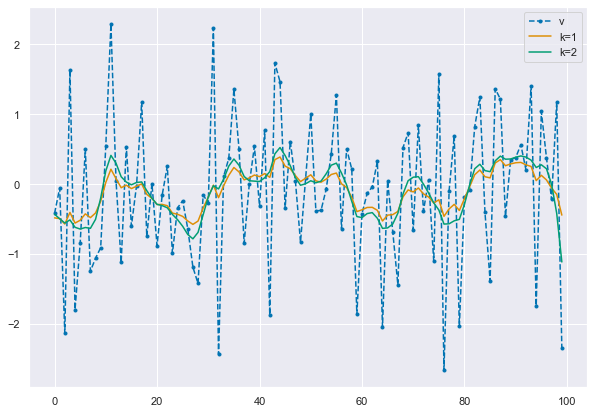

In [45]:
np.random.seed(2)
x = np.random.randn(100)
plt.figure(figsize=(10,7))
plt.plot(x, label='v', ls='--', marker='.')
for k in range(2):
    plt.plot(proj_l2_dk(x, k+1, theta=8e1), label='k={}'.format(k+1))
plt.legend()
plt.title('Comparison of ')

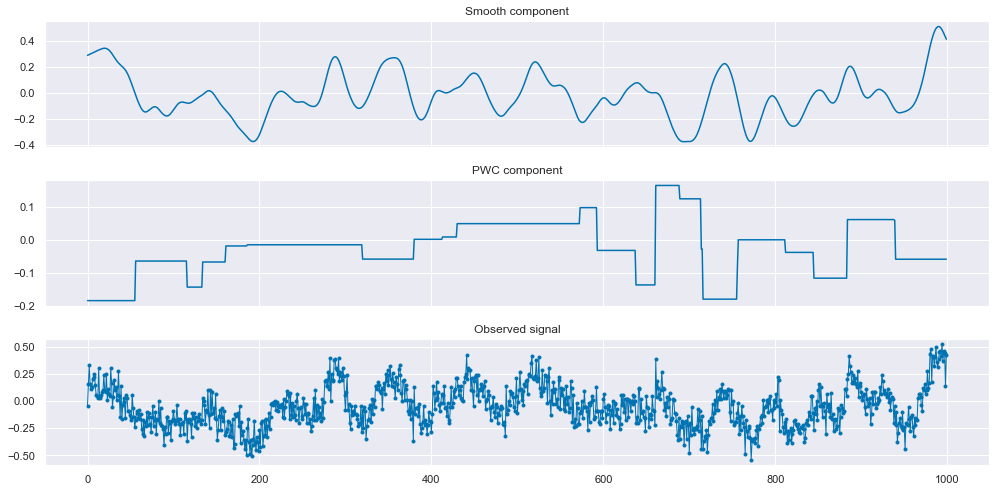

In [35]:
T = 1000
c1 = 0.1 * np.random.randn(T)
c2 = proj_l2_d2(np.random.randn(T), theta=5e2)
c3 = proj_l1_d1(np.random.randn(T), theta=5e-1)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(c2)
ax[1].set_title('PWC component')
ax[1].plot(c3)
ax[2].set_title('Observed signal')
ax[2].plot(c1 + c2 + c3, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

## Old Work

1.0000005388406423
1.0000029992345696
1.0000009035138004
1.0000009193060744
0.9999929283557981


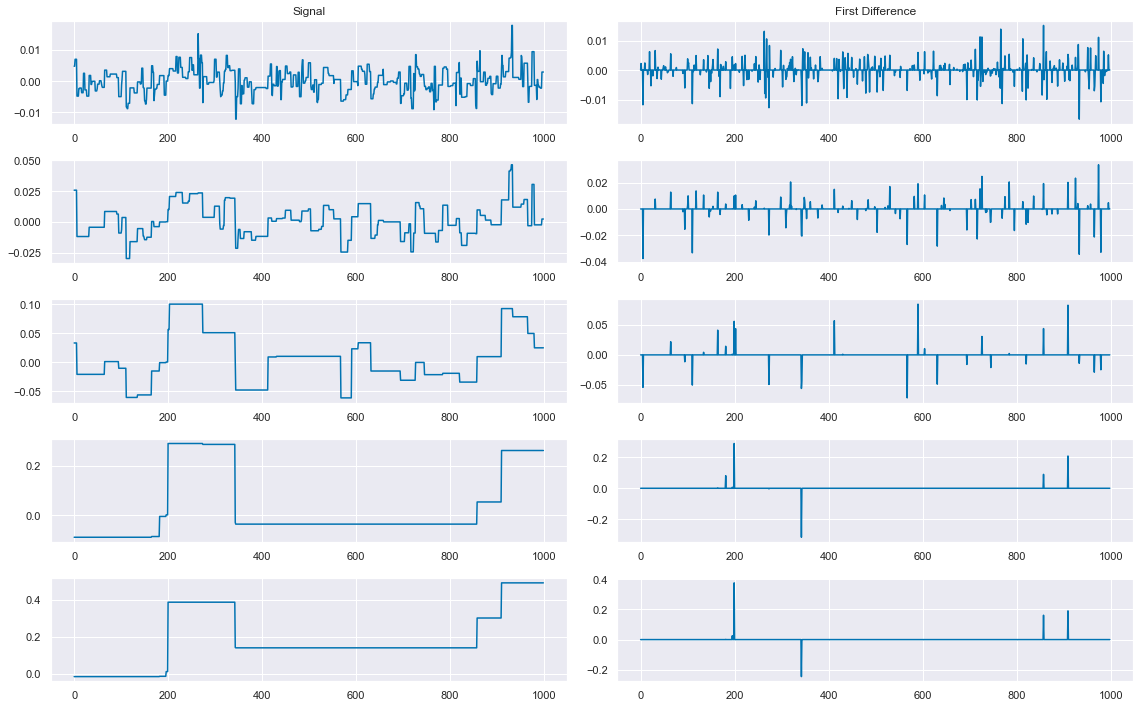

In [168]:
n = 5
x = np.random.randn(1000)
fig, ax = plt.subplots(ncols=2, nrows=n, figsize=(16, 10))
for i, a in enumerate(np.logspace(-2, 1, n)):
    y2 = proj_c2(a * x)
    ax[i, 0].plot(y2)
    ax[i, 1].plot(np.diff(y2, n=1))
    print(cvx.sum(cvx.abs(cvx.diff(y2, k=1))).value)
ax[0, 0].set_title('Signal')
ax[0, 1].set_title('First Difference')
plt.tight_layout()
plt.show()

0.06399217867824865
0.9999999992433465
0.9999999827902433
0.9999999554810096
0.9999931875258342


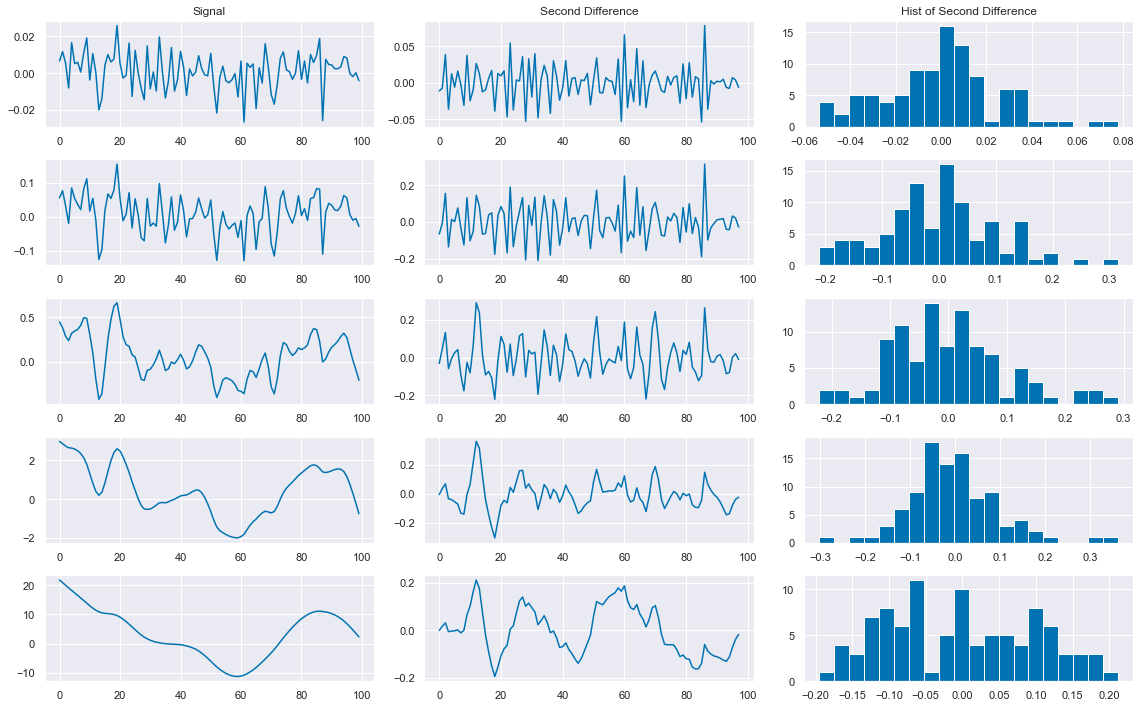

In [174]:
n = 5
x = np.random.randn(100)
fig, ax = plt.subplots(ncols=3, nrows=n, figsize=(16, 10))
for i, a in enumerate(np.logspace(-2, 1.5, n)):
    y4 = proj_c4(a * x)
#     y4 = proj_c4(a * x, np.power(a, -2))
    ax[i, 0].plot(y4)
#     ax[i, 0].plot(a * x)
    ax[i, 1].plot(np.diff(y4, n=2))
    ax[i, 2].hist(np.diff(y4, n=2), bins=20)
#     ax[i, 2].set_xlim(-0.11, 0.11)
    print(cvx.sum(cvx.power(cvx.diff(y4, k=2), 2)).value)
ax[0, 0].set_title('Signal')
ax[0, 1].set_title('Second Difference')
ax[0, 2].set_title('Hist of Second Difference')
plt.tight_layout()
plt.show()


402.9203454046836
177.82794093056026
3.1622776351058133
0.05623413255131775
0.001000000286186764


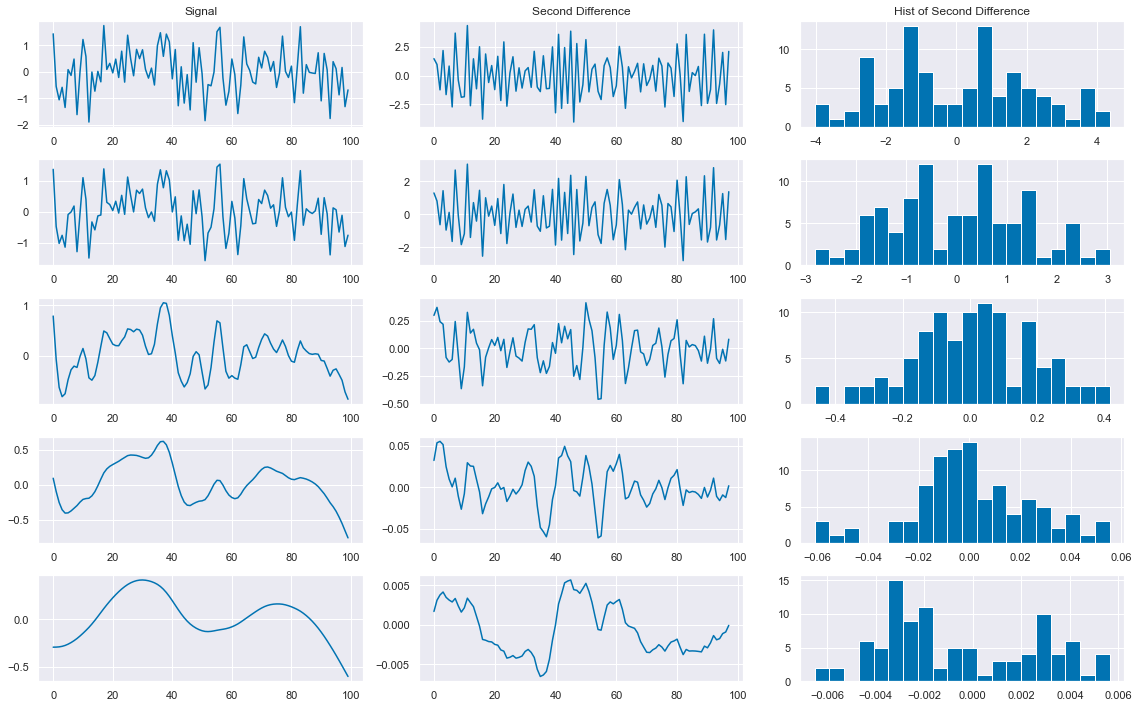

In [170]:
n = 5
# x = np.random.randn(100)
fig, ax = plt.subplots(ncols=3, nrows=n, figsize=(16, 10))
for i, a in enumerate(np.logspace(-2, 1.5, n)):
    y4 = proj_c4(x, a ** 2)
    ax[i, 0].plot(y4)
    ax[i, 1].plot(np.diff(y4, n=2))
    ax[i, 2].hist(np.diff(y4, n=2), bins=20)
#     ax[i, 2].set_xlim(-0.11, 0.11)
    print(cvx.sum(cvx.power(cvx.diff(y4, k=2), 2)).value)
ax[0, 0].set_title('Signal')
ax[0, 1].set_title('Second Difference')
ax[0, 2].set_title('Hist of Second Difference')
plt.tight_layout()
plt.show()


In [120]:
def resample(smp, scale=1.0):
    """Resample a sound to be a different length
    Sample must be mono.  May take some time for longer sounds
    sampled at 44100 Hz.

    Keyword arguments:
    scale - scale factor for length of sound (2.0 means double length)
    """
    # f*ing cool, numpy can do this with one command
    # calculate new length of sample
    n = round(len(smp) * scale)
    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    return np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False), # where to interpret
        np.linspace(0.0, 1.0, len(smp), endpoint=False), # known positions
        smp, # known data points
        )


In [175]:
resampled = [resample(c3, k) for k in np.logspace(0, -1.75, 20)]
truncated = [c3[:len(sig)] for sig in resampled]
lengths  = [len(sig) for sig in resampled]
costs_r = [cvx.sum(cvx.power(cvx.diff(sig, k=2), 2)).value / (len(sig) - 2) for sig in resampled]
costs_t = [cvx.sum(cvx.power(cvx.diff(sig, k=2), 2)).value / (len(sig) - 2) for sig in truncated]

In [176]:
truncated[0]

array([0.48248301, 0.49155702, 0.50057363, ..., 0.46418062, 0.47335607,
       0.48248301])

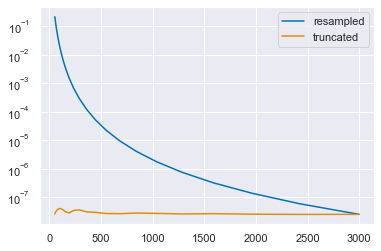

In [177]:
plt.plot(lengths, costs_r, label='resampled')
plt.plot(lengths, costs_t, label='truncated')
plt.yscale('log')
plt.legend();

In [167]:
costs_r

[7.673310861706762e-05,
 0.00014525572507435115,
 0.0002748676265118046,
 0.0005172327146802768,
 0.0009786576480700358,
 0.0018458730584303223,
 0.003492330529018423,
 0.00657915616911528,
 0.012424242891943695,
 0.023430180003736936,
 0.04417789897864903,
 0.0834232530989964,
 0.1577630849549234,
 0.29665956256436243,
 0.5519026982699999,
 1.0173268206758002,
 1.8848163210267872,
 3.4020932988815558,
 6.168940965483879,
 10.907481961838892]

1.0000001738834152 1.000000711930769 1.0000005825188418 0.9999997743806365


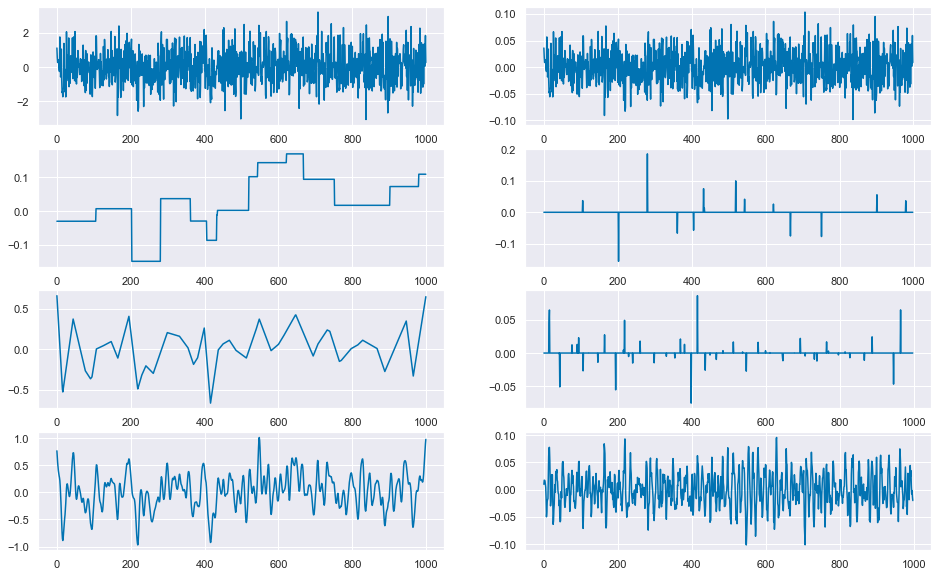

In [68]:
x = np.random.randn(1000)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))
y1 = proj_c1(x)
y2 = proj_c2(x)
y3 = proj_c3(x)
y4 = proj_c4(x)
ax[0, 0].plot(x)
ax[0, 1].plot(y1)
ax[1, 0].plot(y2)
ax[2, 0].plot(y3)
ax[3, 0].plot(y4)
ax[1, 1].plot(np.diff(y2, n=1))
ax[2, 1].plot(np.diff(y3, n=2))
ax[3, 1].plot(np.diff(y4, n=2))
print(np.sum(np.power(y1, 2)),
      cvx.sum(cvx.abs(cvx.diff(y2, k=1))).value,
      cvx.sum(cvx.abs(cvx.diff(y3, k=2))).value,
      cvx.sum_squares(cvx.diff(y4, k=2)).value)
plt.show();

1.0000000521863597 1.0000000997036214 1.000003808109345 0.9999999952586391


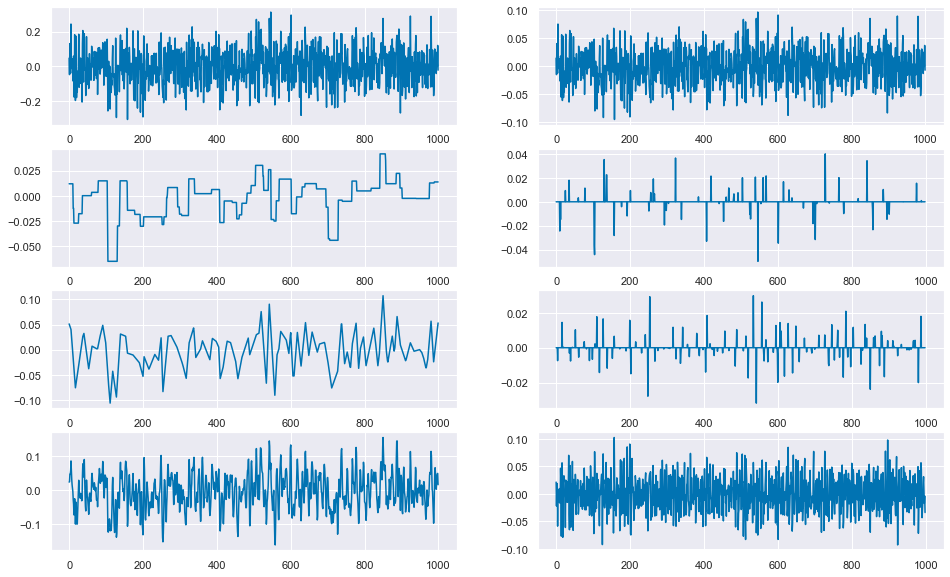

In [70]:
x = np.random.randn(1000) * .1
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))
y1 = proj_c1(x)
y2 = proj_c2(x)
y3 = proj_c3(x)
y4 = proj_c4(x)
ax[0, 0].plot(x)
ax[0, 1].plot(y1)
ax[1, 0].plot(y2)
ax[2, 0].plot(y3)
ax[3, 0].plot(y4)
ax[1, 1].plot(np.diff(y2, n=1))
ax[2, 1].plot(np.diff(y3, n=2))
ax[3, 1].plot(np.diff(y4, n=2))
print(np.sum(np.power(y1, 2)),
      cvx.sum(cvx.abs(cvx.diff(y2, k=1))).value, 
      cvx.sum(cvx.abs(cvx.diff(y3, k=2))).value,
      cvx.sum_squares(cvx.diff(y4, k=2)).value)
plt.show();

1.0004380616560682 0.9999188186669551 1.0000199870170712 0.9999947671609435


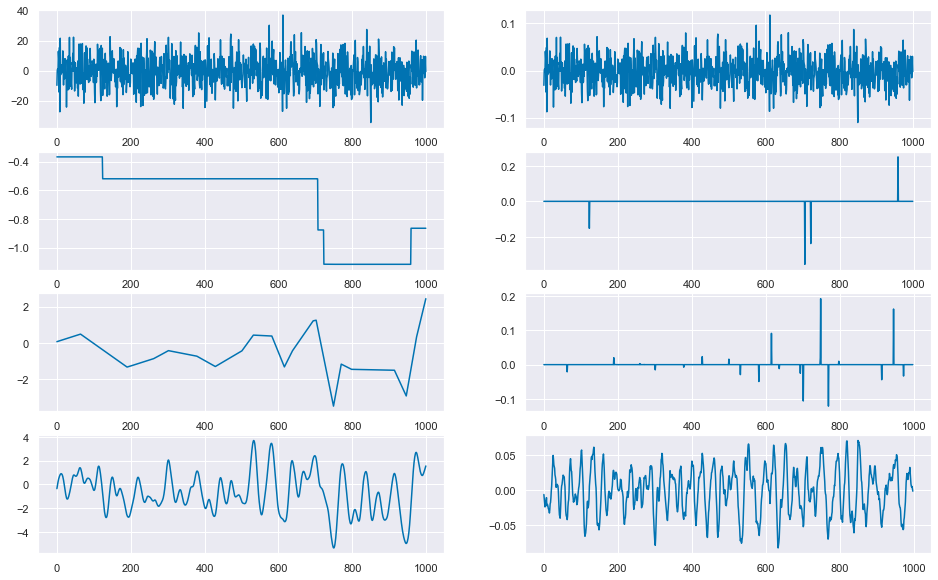

In [71]:
x = np.random.randn(1000) * 10
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))
y1 = proj_c1(x)
y2 = proj_c2(x)
y3 = proj_c3(x)
y4 = proj_c4(x)
ax[0, 0].plot(x)
ax[0, 1].plot(y1)
ax[1, 0].plot(y2)
ax[2, 0].plot(y3)
ax[3, 0].plot(y4)
ax[1, 1].plot(np.diff(y2, n=1))
ax[2, 1].plot(np.diff(y3, n=2))
ax[3, 1].plot(np.diff(y4, n=2))
print(np.sum(np.power(y1, 2)),
      cvx.sum(cvx.abs(cvx.diff(y2, k=1))).value, 
      cvx.sum(cvx.abs(cvx.diff(y3, k=2))).value,
      cvx.sum_squares(cvx.diff(y4, k=2)).value)
plt.show();

In [13]:
for i in range(4):
    print(problem.components[i].cost(problem.estimates[i]).value)

177.6823849328021
11.904729866484711
0.17573777976867966
0.00011976396265921025


In [52]:
for i in range(4):
    print(problem.components[0].cost(problem.estimates[0]).value /
          problem.components[i].cost(problem.estimates[i]).value)

1.0
17.958482217329387
1525.4598040808094
4446140.6197378645


In [16]:
param_search = np.logspace(-1, 5, 13)
nvals = len(param_search) ** 3
results = pd.DataFrame(columns=['w1', 'w2', 'w3', 'resid_cost'], index=range(nvals))
counter = 0
ti = time()
for w1 in param_search:
    for w2 in param_search:
        for w3 in param_search:
            tnow = time()
            msg = ' {:.2f} minutes'.format((tnow - ti) / 60.)
            progress(counter, nvals, msg)
            problem.weights.value = [1., w1, w2, w3]
            problem.decompose(solver='MOSEK')
            results.loc[counter] = [w1, w2, w3, problem.holdout_validation(solver='MOSEK', seed=42)]
            counter += 1
tnow = time()
msg = ' complete, {:.2f} minutes'.format((tnow - ti) / 60.)
progress(counter, nvals, msg)
progress(counter, nvals)

KeyboardInterrupt: 

In [15]:
results = results.astype(np.float)

In [16]:
results.loc[results['resid_cost'].idxmin()]

w1                 3.162278
w2                31.622777
w3            100000.000000
resid_cost        45.821953
Name: 584, dtype: float64

In [17]:
best = results.loc[results['resid_cost'].idxmin()]
problem.weights.value = [1., best['w1'], best['w2'], best['w3']]
problem.demix(solver='MOSEK')

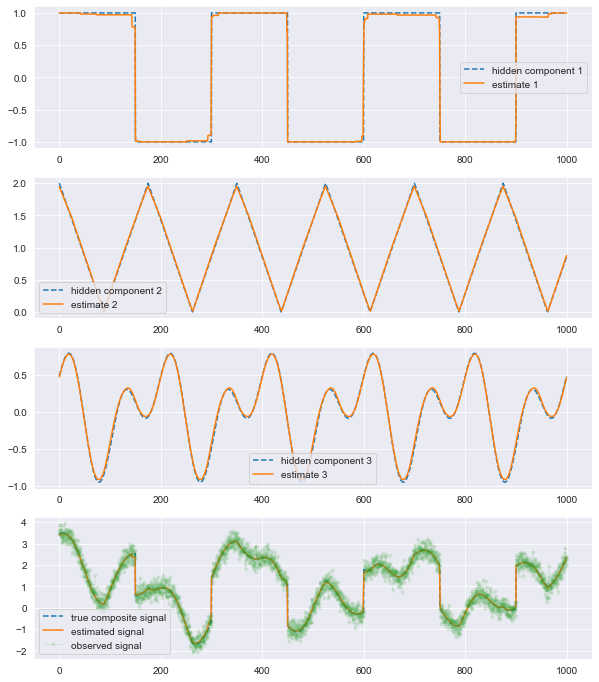

In [18]:
fig, ax = plt.subplots(nrows=4, figsize=(10, 12))
ax[0].plot(t, c1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, c2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, c3, label='hidden component 3', ls='--')
ax[2].plot(t, problem.estimates[3], label='estimate 3')
ax[3].plot(t, c1 + c2 + c3, label='true composite signal', ls='--')
ax[3].plot(t, problem.estimates[1] + problem.estimates[2] + problem.estimates[3], label='estimated signal');
ax[3].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()